In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

import dionysus as d
import sklearn_tda as tda

from biomarker.data_collection import *

Cython not found--WassersteinDistance not available
Gudhi not found--GraphInducedComplex not available
data_collection


In [2]:
EXCLUDE_KEYS = [206, 205, 184, 183, 82, 81, 45]
TEST_KEYS = [217, 216]#, 215, 214, 213, 212, 211, 210, 209]
NUM_TEST = 10
SIGMA = 1

C = 1
EPSILON = 0.1
GAMMA = 0.1
LIM = 5
MUL = 10

In [3]:
def compute_diagram(points, k=3):
    r = np.max(pdist(points, 'euclidean'))
    f = d.fill_rips(points, k, r)
    m = d.homology_persistence(f)
    return d.init_diagrams(m, f)

def get_max_diag_dim(dgms, h=1):
    m = 0
    for d in dgms:
        n = len(d[h])
        if n > m:
            m = n
    return m

def kernelize_diagrams_rbf(dgms, h=1, sigma=SIGMA, default=10):
    D = np.zeros(shape=(len(dgms), len(dgms)))
    for i in range(len(dgms)):
        print('step: ', i)
        for j in range(len(dgms)):
            if i == j:
                D[i,j] = 0.0
            else:
                xi = np.zeros(((len(dgms[i][h]) if len(dgms[i][h]) > len(dgms[j][h]) else len(dgms[j][h])), 2))
                xj = np.zeros(xi.shape)
                if xj.shape[0] > 0:
                    for ip in range(len(dgms[i][h])):
                        xi[ip,0] = dgms[i][h][ip].birth
                        xi[ip,1] = dgms[i][h][ip].death
                    for jp in range(len(dgms[j][h])):
                        xj[jp,0] = dgms[j][h][ip].birth
                        xj[jp,1] = dgms[j][h][ip].death
                    xi[xi[:,1] >= 1E108] = 0
                    xj[xj[:,1] >= 1E108] = 0
                    D[i,j] = np.exp(np.power((np.linalg.norm(xi - xj, 2)), 2)/(2*sigma))
    #                 D[D >= 1E108] = 0
                else:
                    D[i,j] = 0
                D = np.nan_to_num(D)
    return D

def kernelize_diagrams(dgms, h=1, sigma=SIGMA):
    D = np.zeros(shape=(len(dgms), len(dgms)))
    for i in range(len(dgms)):
        print('step: ', i)
        for j in range(len(dgms)):
            if i == j:
                D[i,j] = 0.0
            else:
                D[i,j] = d.bottleneck_distance(dgms[i][h], dgms[j][h])
#                 D[i,j] = np.exp(d.wasserstein_distance(dgms[i][h], dgms[j][h], q=2)/2*sigma)
    D = np.nan_to_num(D)
    return D


def compute_sample_weights(y, lim=LIM, mul=MUL):
    ret = np.ones(y.shape[0])
    for i in range(y.shape[0]):
        v = y[i]
        if v < lim:
            ret[i] = (lim-v)*mul
    return ret

def create_train_test_matrices(train_keys, test_keys):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    x1_train, x1_dims = create_x1_matrix(L_train, return_dims=True)
    x4_train, x4_dims = create_x4_matrix(L_train, return_dims=True)
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x6_train, x6_dims = create_x6_matrix(L_train, return_dims=True)
    x7_train, x7_dims = create_x7_matrix(L_train, return_dims=True)
    
    x1_test = create_x1_matrix(L_test, max_dims=x1_dims)
    x4_test = create_x4_matrix(L_test, max_dims=x4_dims)
    x5_test = create_x5_matrix(L_test, max_dims=x5_dims)
    x6_test = create_x6_matrix(L_test, max_dims=x6_dims)
    x7_test = create_x7_matrix(L_test, max_dims=x7_dims)
    
    x10_x17_train = excel_train.iloc[:, 3:-2]
    master_train, master_names = prepare_master(x10_x17_train)
    
    x10_x17_test = excel_test.iloc[:, 3:-2]
    master_test, master_names = prepare_master(x10_x17_test)
    
    X_train = np.hstack((x1_train,x4_train,x5_train,x6_train,x7_train))
    X_test = np.hstack((x1_test, x4_test, x5_test, x6_test, x7_test))
    
    X = np.vstack((X_train,X_test))
    K = rbf_kernel(X)
    X_train = K[:len(y_train), :len(y_train)]
    X_test = K[len(y_train):, :len(y_train)]
    
    return (X_train, y_train), (X_test, y_test)

def create_train_test_diagram_kernels(train_keys, test_keys, h=1):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    print('Computing Training Diagrams')
    diags_train = []
    for l in L_train:
        diags_train.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_train)):
        if len(diags_train[i][h]) == 0:
            diags_train[i] = np.array([[0,0]])
        else:
            diags_train[i] = np.array([[pt.birth,pt.death] for pt in diags_train[i][h]])
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_train + diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=1, bandwidth=1.)
    
    D = SW.fit_transform(dd)
    
    D_train = D[:len(y_train), :len(y_train)]
    D_test = D[len(y_train):, :len(y_train)]
    return (D_train, y_train), (D_test, y_test)
      
    
def create_test_diagram_distances(h=1, num_points=1):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    excel_test = excel
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    diag_dists = np.zeros((len(diags_test),num_points))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) < num_points:
            for j in range(len(diags_test[i][h])):
                diag_dists[i,j] = diags_test[i][h][j].death - diags_test[i][h][j].birth
        else:
            j = 0
            for pt in diags_test[i][h]:
                if j >= num_points:
                    break
                else:
                    print(diag_dists.shape)
                    print(diags_test[i][h])
                    diag_dists[i,j] = pt.death - pt.birth
                    j += 1
        
    return (diag_dists, y_test)
      

In [4]:
excel = parse_master_file(exclude_keys=EXCLUDE_KEYS).reset_index()
keys = excel['Key']

[3, 9]


In [5]:
# train_set, test_set = create_train_test_matrices(train_keys, TEST_KEYS)
# X_train = train_set[0]
# X_test = test_set[0]
# print(X_train.shape)

In [6]:
test_set = create_test_diagram_distances(num_points=1)
X = test_set[0]
y = test_set[1]

[3, 9]
Computing Test Diagrams
(196, 1)
Diagram with 3 points
(196, 1)
Diagram with 3 points
(196, 1)
Diagram with 2 points
(196, 1)
Diagram with 15 points
(196, 1)
Diagram with 2 points
(196, 1)
Diagram with 1 points
(196, 1)
Diagram with 1 points
(196, 1)
Diagram with 1 points
(196, 1)
Diagram with 1 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 2 points
(196, 1)
Diagram with 3 points
(196, 1)
Diagram with 3 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 3 points
(196, 1)
Diagram with 4 points
(196, 1)
Diagram with 1 points
(196, 1)
Diagram with 1 points
(196, 1

In [7]:
best_score = -float('inf')
# clf = DecisionTreeRegressor(max_depth=1)
clf = LinearRegression()
cvs = cross_val_score(clf, X, y, cv=5, scoring='neg_median_absolute_error')
print('Mean Cross-Validation Score: {}, Stddev: {}'.format(cvs.mean(), cvs.std()))
if cvs.mean() > best_score:
    best_score = cvs.mean()
    best_cvs = cvs
    best_params = []

Mean Cross-Validation Score: -1.7668743844945651, Stddev: 0.6974976079070971


/Users/tgebhart/.virtualenvs/biomarker/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [8]:
results = []
for i in range(X.shape[0]):
    y_train = np.delete(y, i, axis=0)
    y_test = y[i]
    X_train = np.delete(X, i, axis=0)
    X_test = X[i].reshape(1,-1)
#     clf = DecisionTreeRegressor(max_depth=2)
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    results.append({'predicted':prediction[0], 'actual':y_test})

In [9]:
res_df = pd.DataFrame(results)
res_df.head(10)

,actual,predicted
0,4.39,6.519089
1,4.39,6.519089
2,4.63,6.613915
3,4.80,6.524578
4,4.90,6.649010
5,5.55,6.617130
6,6.31,6.661471
7,6.32,6.661396
8,6.92,6.634593
9,7.12,6.575755


In [10]:
res_df.tail(10)

,actual,predicted
186,7.95,6.572625
187,5.52,6.598732
188,8.74,6.610108
189,8.14,6.517180
190,4.00,6.091662
191,6.54,6.575556
192,0.00,6.622707
193,0.00,6.600352
194,0.00,6.725266
195,0.00,6.811845


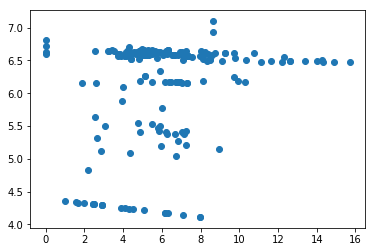

In [11]:
plt.scatter(res_df['actual'], res_df['predicted'])